<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
## Import libraries
import gym
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from collections import namedtuple, deque

Our current state is represented by a 210x160x3 Tensor. This represents the height, length, and the three RGB color channels of the Atari game.

In [2]:
## Initiate the environment
env = gym.make("MsPacman-v0")

print('State shape is {}\n'.format(env.observation_space.shape))
print('Possible actions are {}: '.format(env.action_space.n))
print(env.env.get_action_meanings())

State shape is (210, 160, 3)

Possible actions are 9: 
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
## Create a class that stores the agent's experiences and retrieves random batches from its memory
class ReplayMemory:
    
    def __init__(self, capacity=10000, batch_size=32):
        """Initiate the class parameters"""
        self.capacity = capacity
        self.batch_size = batch_size
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

    def push(self, state, action, reward, next_state, done):
        """Add a new experience to the memory buffer"""
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def __len__(self):
        return len(self.buffer)        
        
    def sample(self):
        """Sample a random batch of experiences from the memory"""
        samples = random.sample(self.buffer, self.batch_size)

        states = np.array([state[0] for state in samples])
        actions = np.array([action[1] for action in samples])
        rewards = np.array([reward[2] for reward in samples])
        next_states = np.array([next_state[3] for next_state in samples])
        dones = np.array([done[4] for done in samples])
        
        return (states, actions, rewards, next_states, dones)
    


In [5]:
import random
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.optimizers import Adam

class DQNAgent:

    def __init__(self, observation_space, action_space, capacity=10000, batch_size=32, 
                 learning_rate=0.001, gamma = 0.95, epsilon=1.0, epsilon_min = 0.05, epsilon_decay = 0.9999):
        """Creates an instance of a Deep-Q-Network Agent"""
        self.state_shape = observation_space.shape # shape of any given state
        self.action_size = action_space.n # number of possible actions
        self.learning_rate = learning_rate # model's learning rate
        self.gamma = gamma # discount rate
        self.batch_size = batch_size # size of batches sampled from memory
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min # threshold of epsilon
        self.epsilon_decay = epsilon_decay # decay of exploration rate
        self.model = self.build_model() # instance of dqn model
        self.memory = ReplayMemory(capacity=capacity, batch_size=self.batch_size) # expirience replay memory

    def build_model(self):
        """Build the Convolutional DQN model"""
        model = Sequential()
        # add convolutional layers
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.state_shape))
        model.add(Conv2D(64, (3, 2), activation='relu'))
        model.add(Conv2D(64, (3, 2), activation='relu'))
        model.add(Flatten())
        # add fully connected layers with dropout
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.action_size, activation='linear'))
        # compile model with MSE loss and Adam optimizer
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def get_action(self, state):
        """Select action according to the epsilon-greedy policy"""
        # get the correct dimension that the models accepts
        # transform state from shape (210,160,3) to (1,210,160,3)
        state = np.expand_dims(state, axis=0) 
        action = self.model.predict(state)
        if random.random() > self.epsilon:
            return np.argmax(action) # exploitation
        else:
            return random.choice(np.arange(self.action_size)) # exploration

    def train_model(self, states, actions, rewards, next_states, dones):
        """Train the model using random batches of experiences from the memory"""
        states, actions, rewards, next_states, dones = self.memory.sample() # random memory sample
        # iterate over the batch
        for i in range(len(states)):
            state, action, reward, next_state, done = states[i], actions[i], rewards[i], next_states[i], dones[i]

            state = np.expand_dims(state, axis=0)
            next_state = np.expand_dims(next_state, axis=0)

            target = self.model.predict(state)
            target_val = self.model.predict(next_state)

            if done:
                target[0][action] = reward
            else:
                target[0][action] = (reward + self.gamma * np.max(target))
            
            # get the loss of the model
            loss = self.model.fit(state, target, verbose=0).history['loss'][0]
            return loss

Using TensorFlow backend.


In [6]:
EPISODES = 200 # Number of episodes
losses = []

# Get an instance of a DQN agent
dqnAgent = DQNAgent(env.observation_space, env.action_space, capacity=10000, batch_size=32, 
                 learning_rate=0.001, gamma = 0.95, epsilon=1.0, epsilon_min = 0.05, epsilon_decay = 0.9999)

In [7]:
## Train the agent
print('Training initiated...')
ep_rewards = []
for episode in range(1, EPISODES+1):
    init_time = time()
    state = env.reset()
    ep_reward = 0
    done=False
    while not done:
        action = dqnAgent.get_action(state)
        next_state, reward, done, info = env.step(action)
        dqnAgent.memory.push(state, action, reward, next_state, done)
        ep_reward += reward
        state = next_state

        if dqnAgent.epsilon >= dqnAgent.epsilon_min: 
            dqnAgent.epsilon *= dqnAgent.epsilon_decay # decaying exploration/exploitation
    time_taken = time() - init_time
    loss = dqnAgent.train_model(action, state, next_state, reward, done)
    losses.append(loss)
    ep_rewards.append(ep_reward)
    if episode % 10 == 0:
        print('Episode {} of {}:\n   reward: {:.2f} \n   loss: {:.2f} \n   \u03B5: {:.3f} \n   time taken: {:.2f} sec'.format(episode, EPISODES, ep_reward, loss, dqnAgent.epsilon, time_taken))
        
print('Training ended.')

Training initiated...
Episode 10 of 200:
   reward: 100.00 
   loss: 291101.72 
   ε: 0.469 
   time taken: 22.22 sec
Episode 20 of 200:
   reward: 540.00 
   loss: 48.66 
   ε: 0.210 
   time taken: 34.20 sec
Episode 30 of 200:
   reward: 1900.00 
   loss: 71.41 
   ε: 0.094 
   time taken: 54.11 sec
Episode 40 of 200:
   reward: 310.00 
   loss: 13.36 
   ε: 0.050 
   time taken: 33.93 sec
Episode 50 of 200:
   reward: 500.00 
   loss: 45.19 
   ε: 0.050 
   time taken: 34.14 sec
Episode 60 of 200:
   reward: 280.00 
   loss: 7.26 
   ε: 0.050 
   time taken: 45.46 sec
Episode 70 of 200:
   reward: 440.00 
   loss: 2.32 
   ε: 0.050 
   time taken: 59.59 sec
Episode 80 of 200:
   reward: 500.00 
   loss: 6.16 
   ε: 0.050 
   time taken: 51.77 sec
Episode 90 of 200:
   reward: 470.00 
   loss: 6.04 
   ε: 0.050 
   time taken: 41.03 sec
Episode 100 of 200:
   reward: 450.00 
   loss: 3.71 
   ε: 0.050 
   time taken: 47.42 sec
Episode 110 of 200:
   reward: 240.00 
   loss: 0.52 
   

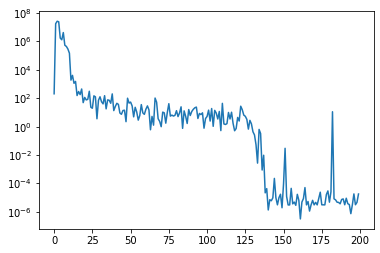

In [11]:
plt.plot(losses)
plt.yscale('log')
plt.show()

In [13]:
min(losses)


3.148962832710822e-07